In [67]:
from sklearn.datasets import make_circles, make_blobs, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import numpy as np
import cvxopt



## Custom SVM implementation by using the Dual Problem 
This implementation provides a custom SVM class supporting linear, polynomial, and radial basis function (RBF) kernels. It uses quadratic programming (QP) to solve the optimization problem and can visualize the decision boundary for 2D datasets.

## From the Primal to the Dual Problem

![../screenshots/Screenshot from 2024-12-31 19-20-17.png](<attachment:Screenshot from 2024-12-31 19-20-17.png>)
## Write the lagrangian
![Screenshot from 2025-01-05 21-34-41.png](<attachment:Screenshot from 2025-01-05 21-34-41.png>)
## Calculate the gradients and set them to zero 
![Screenshot from 2025-01-05 21-34-55.png](<attachment:Screenshot from 2025-01-05 21-34-55.png>) 
![Screenshot from 2025-01-05 21-35-04.png](<attachment:Screenshot from 2025-01-05 21-35-04.png>) 
![Screenshot from 2025-01-05 21-35-12.png](<attachment:Screenshot from 2025-01-05 21-35-12.png>) 
![Screenshot from 2025-01-05 21-35-18.png](<attachment:Screenshot from 2025-01-05 21-35-18.png>)
## Plug the formulas back in to the lagrangian 
![Screenshot from 2025-01-05 21-40-52.png](<attachment:Screenshot from 2025-01-05 21-40-52.png>)

## Decision Rule
The sign of this function determines the class.<br/>
![Screenshot from 2024-12-31 20-23-57.png](<attachment:Screenshot from 2024-12-31 20-23-57.png>)


### Steps for Implementation

Define parameters like C (regularization), kernel (type of kernel), degree (for polynomial kernel), and gamma (for RBF kernel). 
1. <b>Kernel Matrix Construction</b>: The kernel matrix 𝐾 is computed based on the chosen kernel: linear, polynomial or rbf.
![Screenshot from 2024-12-31 19-20-17.png](<attachment:Screenshot from 2024-12-31 19-20-17.png>)

2. <b>Set Up the Quadratic Programming Problem</b>: The dual problem is reformulated into a QP problem using matrices.
![Screenshot from 2025-01-05 22-07-01.png](<attachment:Screenshot from 2025-01-05 22-07-01.png>)

3. <b>Solve Using cvxopt.qp</b>: The cvxopt.solvers.qp function is used to solve the QP problem. This returns the optimal values of 𝛼 the dual variables.

4. <b>Identify Support Vectors</b>: Support vectors are data points with non-zero 𝛼 values (within a small tolerance, e.g., 𝛼 > 1𝑒−5). These points define the decision boundary and contribute to the margin.

5. <b>Compute the Bias Term (𝑏)</b>: The bias term 𝑏 is calculated using the support vectors:
![Screenshot from 2024-12-31 19-24-01.png](<attachment:Screenshot from 2024-12-31 19-24-01.png>)
We will use the mean for stability.

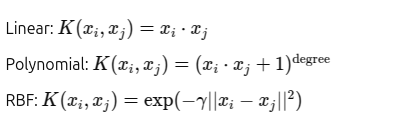
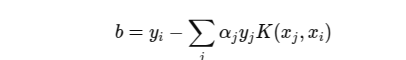
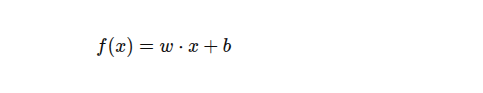
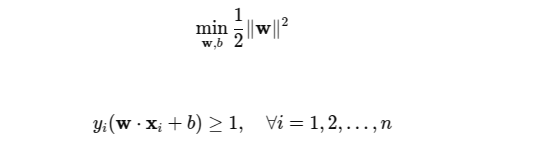
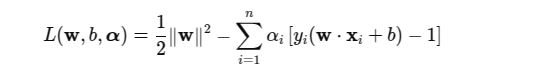
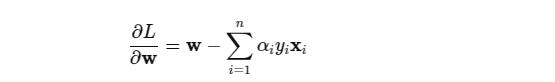
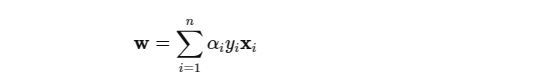
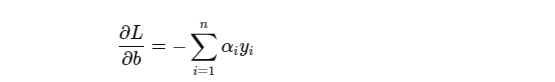
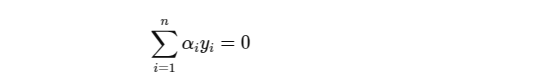
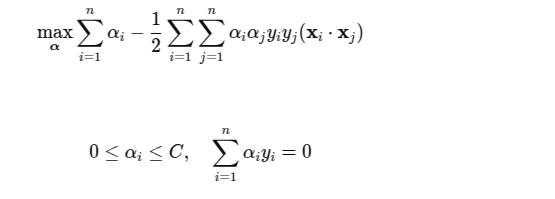
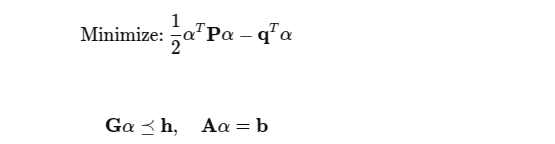

In [ ]:
class SVMDualProblem:
    def __init__(self, C=1.0, kernel='linear', degree=3, gamma='scale'):
        self.C = C
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.alpha = None
        self.support_vectors = None
        self.b = None
        self.kernel_matrix = None
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        if self.kernel == 'linear':
            self.kernel_matrix = np.dot(X, X.T)
        elif self.kernel == 'polynomial':
            self.kernel_matrix = (np.dot(X, X.T) + 1) ** self.degree
        elif self.kernel == 'rbf':
            if self.gamma == 'scale':
                self.gamma = 1 / (n_features * np.var(X))
            else:
                self.gamma = self.gamma
            sq_dists = np.sum(X**2, axis=1).reshape(-1, 1) + np.sum(X**2, axis=1) - 2 * np.dot(X, X.T)
            self.kernel_matrix = np.exp(-self.gamma * sq_dists)
        else:
            raise ValueError("Unsupported kernel")
        
        # Solve the dual problem using QP
        P = cvxopt.matrix(np.outer(y, y) * self.kernel_matrix)
        q = cvxopt.matrix(-np.ones(n_samples))
        G = cvxopt.matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
        h = cvxopt.matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C)))
        A = cvxopt.matrix(y.reshape(1, -1).astype(float))
        b = cvxopt.matrix(np.zeros(1))

        # Solve using cvxopt's QP solver
        cvxopt.solvers.options['show_progress'] = False
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        self.alpha = np.array(solution['x']).flatten()

        # Compute the support vectors (those with alpha > 0)
        sv_indices = self.alpha > 1e-5
        self.support_vectors = X[sv_indices]
        self.alpha = self.alpha[sv_indices]
        self.y_sv = y[sv_indices]

        b_values = []
        for i in range(len(self.support_vectors)):
            b_i = self.y_sv[i] - np.sum(self.alpha * self.y_sv * self.kernel_matrix[sv_indices, i])
            b_values.append(b_i)
        self.b = np.mean(b_values)  # Take the average of the b values from all support vectors

    def predict(self, X):
        if self.kernel == 'linear':
            kernel_val = np.dot(X, self.support_vectors.T)
        elif self.kernel == 'polynomial':
            kernel_val = (np.dot(X, self.support_vectors.T) + 1) ** self.degree
        elif self.kernel == 'rbf':
            sq_dists = np.sum(X**2, axis=1).reshape(-1, 1) + np.sum(self.support_vectors**2, axis=1) - 2 * np.dot(X, self.support_vectors.T)
            kernel_val = np.exp(-self.gamma * sq_dists)
        else:
            raise ValueError("Unsupported kernel")

        return np.sign(np.dot(kernel_val, self.alpha * self.y_sv) + self.b)

    def plot_decision_boundary(self, X, y):
        # Create a grid to evaluate model performance
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

        # Predict on the grid
        Z = self.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        # Plot the decision boundary
        plt.contourf(xx, yy, Z, alpha=0.7, cmap='coolwarm', levels=[-1, 0, 1], linestyles=['--', '-', '--'])

        # Highlight the support vectors
        plt.scatter(self.support_vectors[:, 0], self.support_vectors[:, 1], c='yellow', edgecolors='k', marker='o', s=100, label='Support Vectors')

        # Plot the training points
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k', s=50, label='Training Points')

        # Plot the margin lines for linear kernel
        if self.kernel == 'linear':
            w = np.dot(self.alpha * self.y_sv, self.support_vectors)
            margin = 1 / np.linalg.norm(w)
            slope = -w[0] / w[1]
            intercept = -self.b / w[1]
            x_vals = np.linspace(x_min, x_max, 100)
            plt.plot(x_vals, slope * x_vals + intercept, 'k-', label='Decision Boundary')
            plt.plot(x_vals, slope * x_vals + intercept + margin, 'k--', label='Margin')
            plt.plot(x_vals, slope * x_vals + intercept - margin, 'k--')

        plt.legend()
        plt.title("SVM Decision Boundary with Margins")
        plt.xlabel('Mean Radius')
        plt.ylabel("Mean Texture")
        plt.show()


## Testing the code

Classification Report:
               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        42
           1       1.00      1.00      1.00        48

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90

Accuracy Score: 1.0


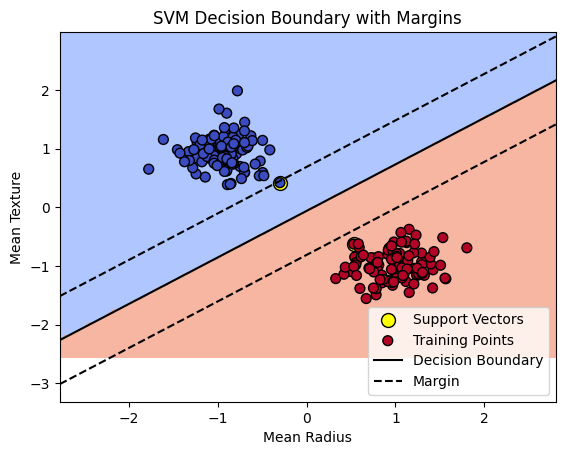

In [69]:
X, y = make_blobs(n_samples=300, centers=2, random_state=42, cluster_std=1)
y = np.where(y == 0, -1, 1)  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svm = SVMDualProblem(C=1, kernel='linear')
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

svm.plot_decision_boundary(X_train, y_train)

Classification Report:
               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        43
           1       1.00      1.00      1.00        47

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90

Accuracy Score: 1.0


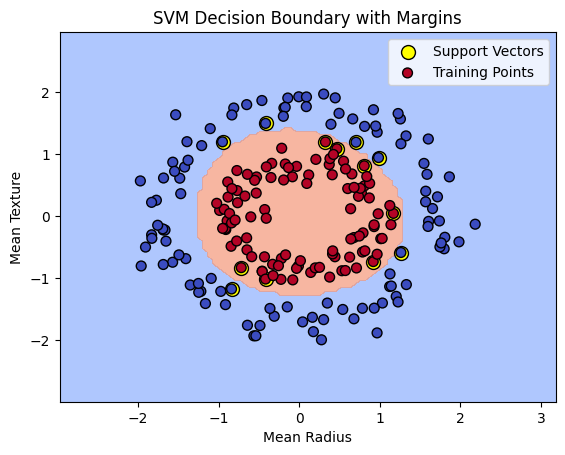

In [70]:
X, y = make_circles(n_samples=300, factor=0.5, noise=0.1)
y = np.where(y == 0, -1, 1)  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svm = SVMDualProblem(C=1, kernel='polynomial')
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

svm.plot_decision_boundary(X_train, y_train)

## Apply on Breast Cancer data

Classification Report:
               precision    recall  f1-score   support

          -1       0.77      0.97      0.86        63
           1       0.98      0.83      0.90       108

    accuracy                           0.88       171
   macro avg       0.88      0.90      0.88       171
weighted avg       0.90      0.88      0.88       171

Accuracy Score: 0.8830409356725146


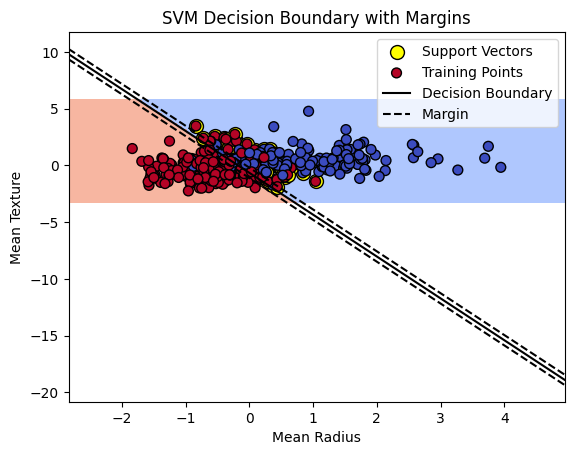

In [71]:
cancer = load_breast_cancer()
X = cancer.data[:, :2]
y = cancer.target

y = np.where(y == 0, -1, 1)  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svm = SVMDualProblem(C=1, kernel='linear')
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

svm.plot_decision_boundary(X_train, y_train)

Classification Report:
               precision    recall  f1-score   support

          -1       0.90      0.84      0.87        63
           1       0.91      0.94      0.93       108

    accuracy                           0.91       171
   macro avg       0.90      0.89      0.90       171
weighted avg       0.91      0.91      0.91       171

Accuracy Score: 0.9064327485380117


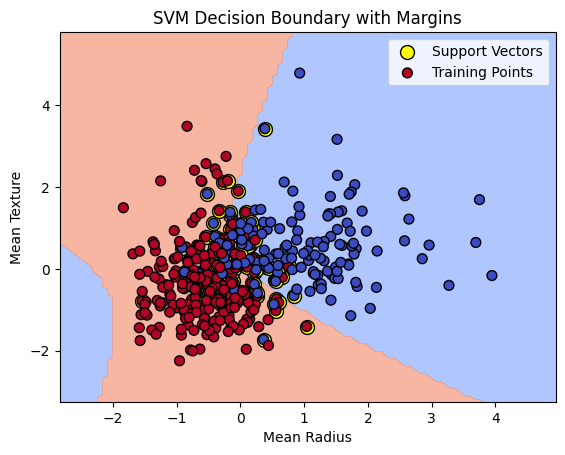

In [72]:
svm = SVMDualProblem(C=1, kernel='polynomial', degree=2)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

svm.plot_decision_boundary(X_train, y_train)

Classification Report:
               precision    recall  f1-score   support

          -1       0.86      0.87      0.87        63
           1       0.93      0.92      0.92       108

    accuracy                           0.90       171
   macro avg       0.89      0.89      0.89       171
weighted avg       0.90      0.90      0.90       171

Accuracy Score: 0.9005847953216374


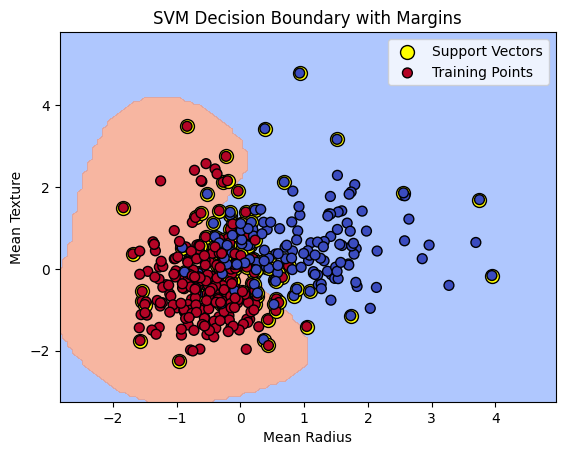

In [73]:
svm = SVMDualProblem(C=1, kernel='rbf')
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

svm.plot_decision_boundary(X_train, y_train)

## Comparing with sklearn's implementation

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.79      0.83        63
           1       0.89      0.94      0.91       108

    accuracy                           0.88       171
   macro avg       0.88      0.86      0.87       171
weighted avg       0.88      0.88      0.88       171

Accuracy Score: 0.8830409356725146


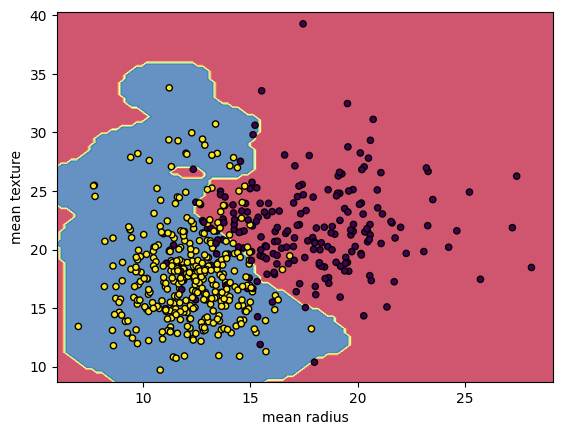

In [74]:
cancer = load_breast_cancer()
X = cancer.data[:, :2]
y = cancer.target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
svm = SVC(kernel="rbf", gamma=0.5, C=1.0)

svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)


print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

DecisionBoundaryDisplay.from_estimator(
        svm,
        X,
        response_method="predict",
        cmap=plt.cm.Spectral,
        alpha=0.8,
        xlabel=cancer.feature_names[0],
        ylabel=cancer.feature_names[1],
    )

# Scatter plot
plt.scatter(X[:, 0], X[:, 1], 
            c=y, 
            s=20, edgecolors="k")
plt.show()
